In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
df = pd.read_csv("train.csv") #train.csv contains 7111 logs
df_train = df.drop("date_time",1)[:5000] #df_train is shape 5000,11
scaler = StandardScaler() 
scaler = scaler.fit(df_train) #computing the parameters for scaling | converts df to numpy array
df_train = scaler.transform(df_train) #scaling the features

df_test = df.drop("date_time",1)[5000:]
df_test = scaler.transform(df_test)


In [28]:
#hyperparameters

sequence_length = 50 #number of steps we are looking back
batch_size = 40
learning_rate = 0.0001
input_size = 11 #the number of features
hidden_size = 32 #size of hidden layer in RNN
output_size = 3 #the targets
num_epochs = 20

In [25]:
#RESHAPING the problem from TIME SERIES to SUPERVISED LEARNING
#X shape --> (length-sequence_length),sequence_length,features 4900,300,11
#y shape --> (length-sequence_length),targets 4900,11

class Train_Time_Series_Dataset(Dataset):
    """creates a dataset for supervised learning from data series"""
    def __init__(self, complete_data,sequence_length):
        X, y = list(), list()
        for i in range(len(complete_data)):
            end_idx = i + sequence_length
            if end_idx > len(complete_data) - 1:
                break
                
            #seq_x shape --> sequence_length, features (for time steps up to t-1)
            #seq_y shape --> targets (for time step t)
            seq_x, seq_y = complete_data[i:end_idx,:], complete_data[end_idx,8:]
            X.append(seq_x)
            y.append(seq_y)
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32)
        
        self.X = torch.from_numpy(X) #converting to tensors
        self.y = torch.from_numpy(y)
        self.sequence_length = sequence_length
        self.n_samples = X.shape[0]
        
    def __getitem__(self,index):
        return self.X[index], self.y[index]
        
    def __len__(self):
        return self.n_samples

#Eval_Dataset is basically used mainly to convert a numpy arrays to tensors and return the data of shape --> "len of input data frame",features
class Eval_Dataset(Dataset):
    """creates a dataset for evaluation"""
    def __init__(self,sequence):
        sequence = np.asarray(sequence, dtype=np.float32)
        self.X = torch.from_numpy(sequence) #converts to tensor
        self.n_samples = sequence.shape[0]
    
    def __getitem__(self, index):
        return self.X[index]

    def __len__(self):
        return self.n_samples

dataset = Train_Time_Series_Dataset(df_train, sequence_length)
train_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True) #train_loader is used to supply data in shuffled BATCHES during training

eval_dataset = Eval_Dataset(df_train) #used for training

test_dataset = Eval_Dataset(df_test) #not used for training

In [9]:
#TESTING dataset and train_loader
dataiter = iter(train_loader)
sample_data =dataiter.next()
#s_features shape --> batch_size, sequence_length, features
#s_targets shape --> batch_size, targets
s_features, s_targets = sample_data
s_features = s_features



In [10]:
#MODEL

"""
note: I often get confused by the dimensions of data going through the neural net; it might be caused by the fact that Pytorch build in neworks
(nn.RNN) always expect batch_size to be one dimension of the data
"""
class RNN(nn.Module):
    def __init__(self,n_features,n_layers,hidden_size,output_size,sequence_length):
        super(RNN,self).__init__()
        self.sequence_length = sequence_length
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(n_features, hidden_size, n_layers, batch_first=True) #expects input of shape --> batch_size, sequence_length, features
        self.fc = nn.Linear(hidden_size, output_size) #fully connected layer
    
    def forward(self,x):
        """forward pass of the data during training"""
        #do not confuse HIDDEN state with WEIGHT matrix!
        h0 = torch.zeros(self.n_layers,x.size(0),self.hidden_size).to(device) #h0 shape --> n_layers, batch_size, hidden_size
        out, _ = self.rnn(x, h0) #returns hidden states for all time steps
        out = out[:,-1,:] #I need only the last hidden state (many to one RNN, see README)
        out = self.fc(out) #out shape --> batch_size, output_size
        return out
    
    #function predict accpets know_sequence as first input and future_sequence that must DIRECTLY follow the known_sequence
    def predict(self,known_sequence, future_sequence):
        """This is a function for predicting future values for arbitrary number of future time steps"""
        with torch.no_grad():
            model.eval() #setting the model to evaluation mode and turning off the gradient computation
            
            known_sequence = known_sequence.to(device) #known_sequence must be longer that sequence_length
            future_sequence = future_sequence.to(device) #future sequence can be of arbitrary length
            
            #X is a temporary data that is going to be updated at each future time step
            x = known_sequence[-self.sequence_length:] #we need only the sequence_length of known data to compute
            x = torch.reshape(x,(1,-1,11)) #x must be of shape --> batch_size, sequence_length, features = 1, 100, 11
            
            outputs = [] #list where outputs of future timesteps will be stored
            
            for i in range(len(future_sequence)): #future_sequence shape --> future_sequence_length, features
                """calculating outputs and updating the x with the newly predicted target variables"""
                #more or less repeating forward pass with batch_size = 1

                h0 = torch.zeros(self.n_layers,1,self.hidden_size).to(device)
                out, _ = self.rnn(x, h0) #out shape --> 1,batch_size,hidden_size
                out = out[:,-1,:] #out shape --> 1,hidden_size
                out = self.fc(out) #out shape --> 1,3
                out = out[0] #out shape --> 3
                
                outputs.append(out)
                
                #preparing the new data point to be added to x
                new_x = future_sequence[i,:8] #known data of the future time step
                new_t = torch.cat((new_x,out),-1) #creating the new data point by concatenating known 8 features with 3 predicted

                x = torch.roll(x,-1,1) #shifting the elements in the tensor by -1 (the first element becomes last)
                x[0,-1] = new_t #replacing the last element with the newly made data point
        
            return outputs
    
model = RNN(input_size,3,hidden_size,output_size,sequence_length).to(device)

#loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
#TRAINING LOOP
n_total_steps = len(train_loader)

running_loss = 0.0

model.train() #setting model to training mode

for epoch in range(num_epochs):
    for i, (features,targets) in enumerate(train_loader):
        #features shape --> batch_size, sequence_length, features
        #targets shape --> batch_size, targets
        features = features.to(device)
        targets = targets.to(device)
        
        #forward
        outputs = model(features)
        loss = criterion(outputs, targets)

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss+= loss.item() #item returns a number

        if (i+1) % 50 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1} / {n_total_steps}, loss = {loss.item()}')
            running_loss = 0.0


#torch.save(model.state_dict(),"mymodel.pth")

epoch 1 / 20, step 50 / 113, loss = 0.4638300836086273
epoch 1 / 20, step 100 / 113, loss = 0.13613516092300415
epoch 2 / 20, step 50 / 113, loss = 0.15732800960540771
epoch 2 / 20, step 100 / 113, loss = 0.13930675387382507
epoch 3 / 20, step 50 / 113, loss = 0.17085686326026917
epoch 3 / 20, step 100 / 113, loss = 0.1436605155467987
epoch 4 / 20, step 50 / 113, loss = 0.16572917997837067
epoch 4 / 20, step 100 / 113, loss = 0.21268565952777863
epoch 5 / 20, step 50 / 113, loss = 0.5810350775718689
epoch 5 / 20, step 100 / 113, loss = 0.19352062046527863
epoch 6 / 20, step 50 / 113, loss = 0.22948679327964783
epoch 6 / 20, step 100 / 113, loss = 0.19807207584381104
epoch 7 / 20, step 50 / 113, loss = 0.10076972842216492
epoch 7 / 20, step 100 / 113, loss = 0.12685008347034454
epoch 8 / 20, step 50 / 113, loss = 0.14204256236553192
epoch 8 / 20, step 100 / 113, loss = 0.16573740541934967
epoch 9 / 20, step 50 / 113, loss = 0.11561395227909088
epoch 9 / 20, step 100 / 113, loss = 0.0642

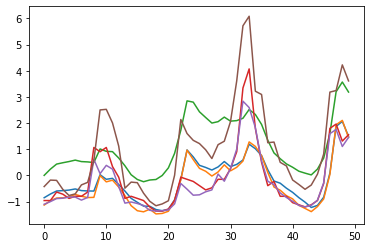

In [30]:
#EVALUATION USING GRAPHS

test_outputs = model.predict(test_dataset[100:800],test_dataset[800:900]) #getting the outputs for data in eval_dataset in second argument of the function predict
test_outputs = torch.stack(test_outputs)
test_outputs = test_outputs.cpu().detach().numpy()

evv = test_dataset[800:900,8:] #the true data of those data points; not used in the "predict" function

plt.plot(test_outputs)
plt.plot(evv)
plt.show()